In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
%matplotlib inline
import warnings
from sklearn.feature_selection import RFECV

warnings.filterwarnings(
    module='scipy',
    action='ignore',
    message='Using a'
    )

In [4]:
raw = pd.read_csv('epi_r.csv')

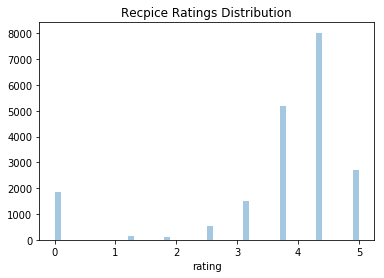

In [5]:
#Chisel the features down to 30 and convert the rating out come into a binary

#fist, look at the out come variable we need to make binary:
g = sns.distplot(raw.rating,kde=False)
plt.title('Recpice Ratings Distribution')
plt.show()

I want to separate the data a 4 rating and up. The indicator will be 'highly rated' vs 'not highly rated'
First, I want to explore the data a bit more

In [6]:
raw.rating.describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

In [7]:
null = raw.isnull().sum()
null[null>0].index

Index(['calories', 'protein', 'fat', 'sodium'], dtype='object')

In [8]:
raw.shape

(20052, 680)

In [9]:
raw = raw.drop(['calories', 'protein', 'fat', 'sodium'],1)

In [10]:
raw.dtypes.head()

title               object
rating             float64
#cakeweek          float64
#wasteless         float64
22-minute meals    float64
dtype: object

In [11]:
#see which ingredients are used the most
cols = []
usage = []
#append attribute names and the percentage used in the data
for col in raw.select_dtypes(include=['float64']):
    cols.append(col)
    usage.append(raw[col].mean())
#pop the 'rating' entry out for plotting purposes'
cols.pop(0)
usage.pop(0)

3.714467384799521

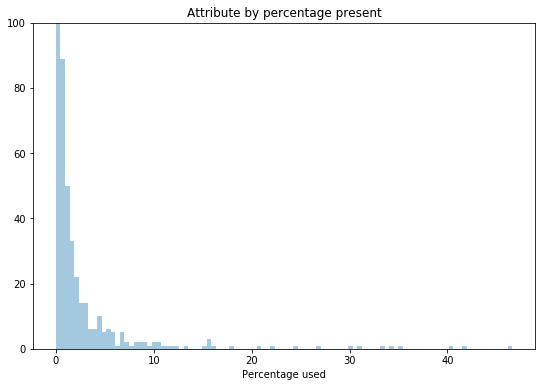

In [12]:
#ingreds = pd.DataFrame()
#ingreds['col'] = cols
#ingreds['usage'] = usage
ingreds = pd.DataFrame(
    sorted(zip(map(lambda x: round(x, 4), usage), 
               cols), reverse=True))
ingreds[0] = ingreds[0]*100
g = plt.figure(figsize=(9,6))
g = sns.distplot(ingreds[0],bins=100,kde=False)
plt.ylim(0,100)
plt.xlabel('Percentage used')
plt.title('Attribute by percentage present')
plt.show()



Obviously, there is a ton of noise in this data. I'm interested to see which attributes show up in over 20% of the recipes.

In [13]:
common = ingreds[ingreds[0]>20]
common

,0,1
0,46.65,bon appétit
1,41.84,peanut free
2,40.34,soy free
3,35.13,tree nut free
4,34.14,vegetarian
5,33.15,gourmet
6,30.79,kosher
7,30.13,pescatarian
8,26.79,quick & easy
9,24.47,wheat/gluten-free


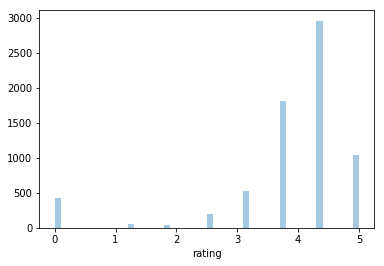

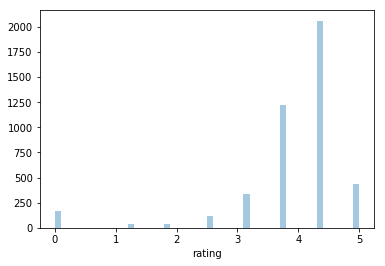

In [14]:
g = sns.distplot(raw.loc[raw['tree nut free']==1]['rating'],kde=False)
plt.show()
g = sns.distplot(raw.loc[raw['bake']==1]['rating'],kde=False)


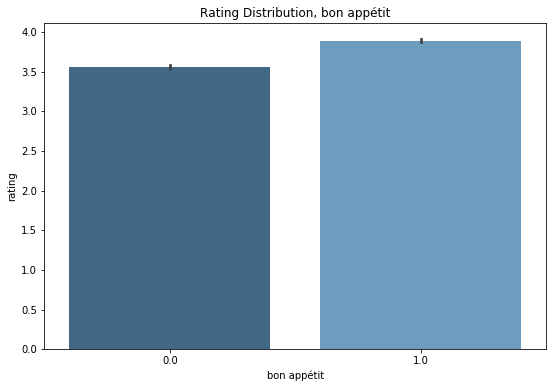

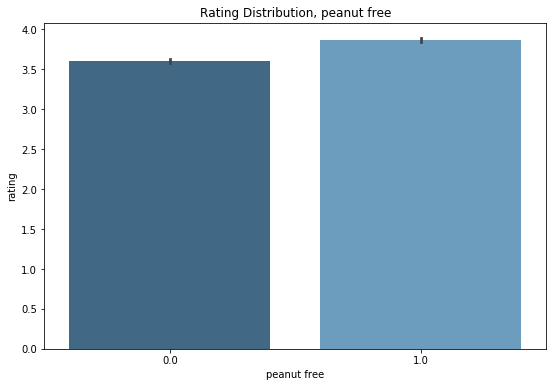

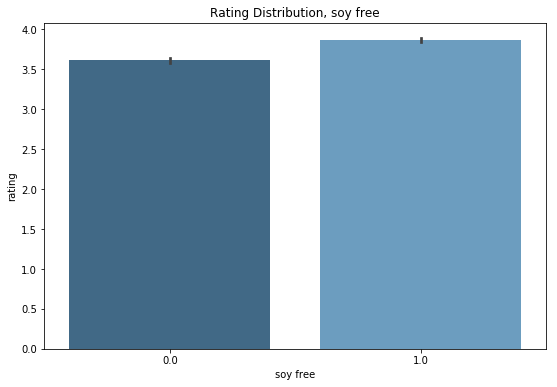

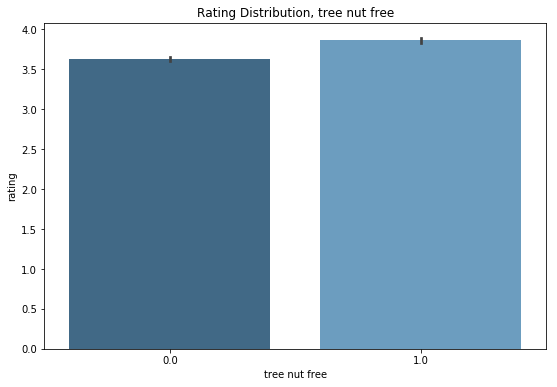

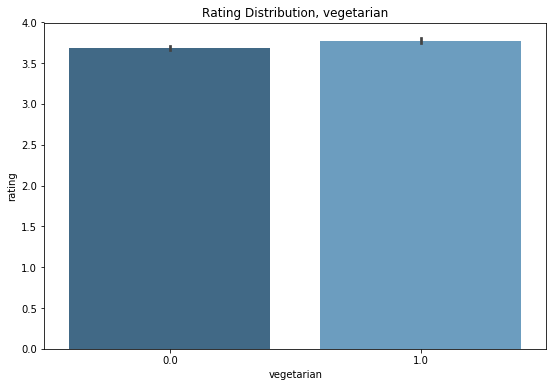

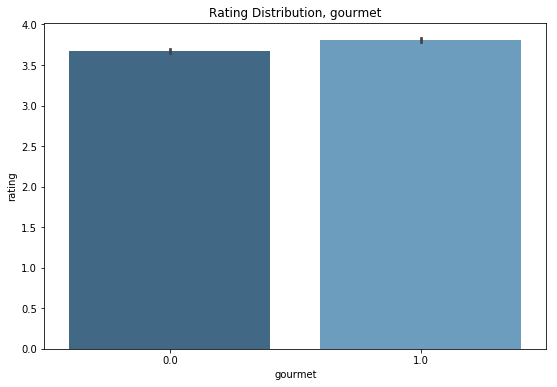

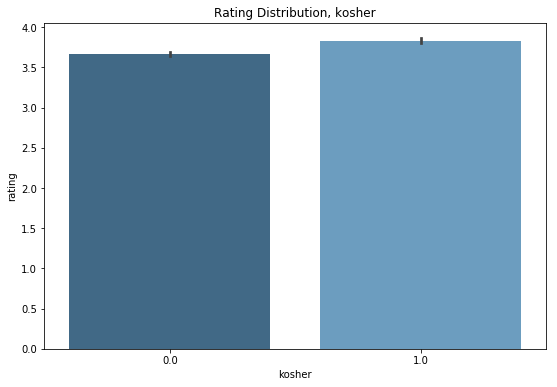

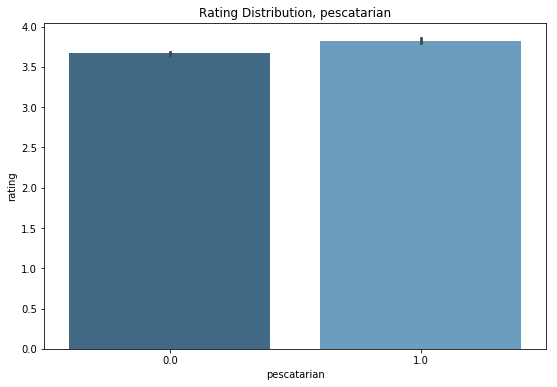

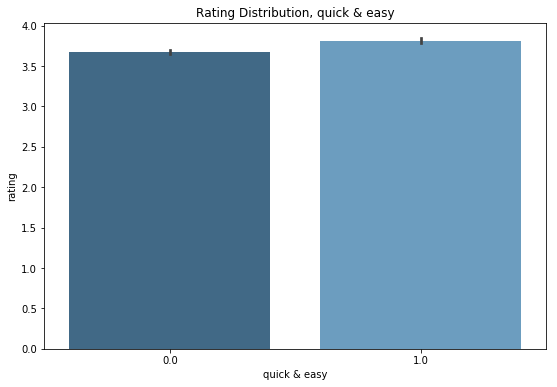

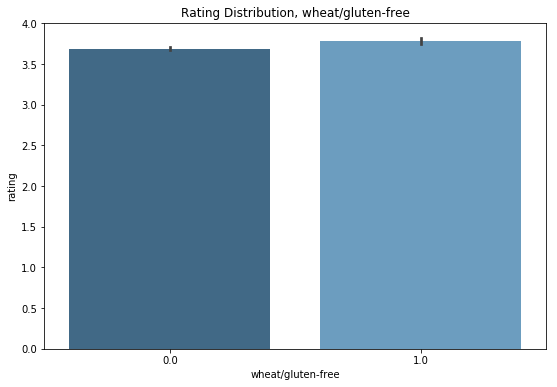

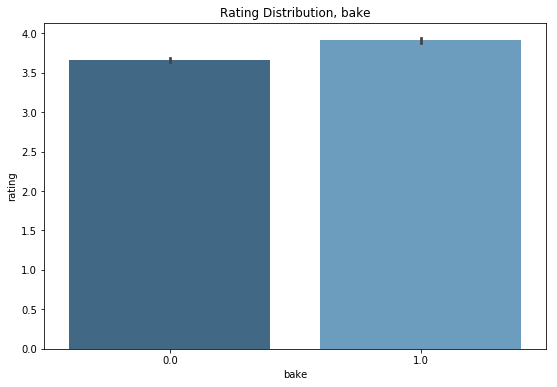

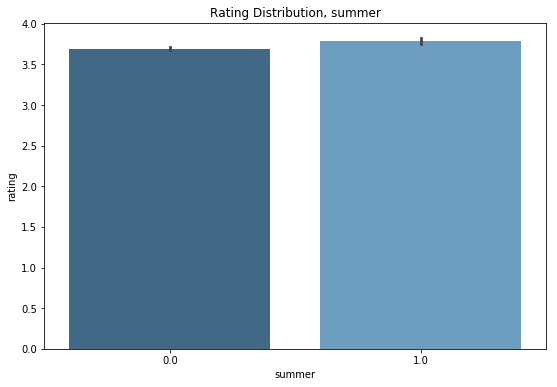

In [15]:
#we can see that not one of these attributes are an ingredient...
#view their relationship to the target variable
#bon appetit seems like it would lean towards a high rating

plotdf = raw.copy()
plotdf.rating = np.where(plotdf['rating']>4,1,0)
for col in common[1]:   
    pdf = pd.DataFrame()
    pdf["g_att"] = plotdf.loc[plotdf[col]==1][col]
    pdf['rate'] = plotdf.loc[plotdf[col]==1]['rating']
    g = plt.figure(figsize=(9,6))
    g = sns.barplot(x=plotdf[col],y=raw['rating'],palette='Blues_d')
    plt.title('Rating Distribution, {}'.format(col))
    plt.show()

out of these 'common' attributes, the only one that stands out is bon appetit. Also, these seems to be categories of food and not ingredients, the ratings would be biased...people who love soy-free are more likely to rate the soy-free recipe...anyway.

(675, 675)


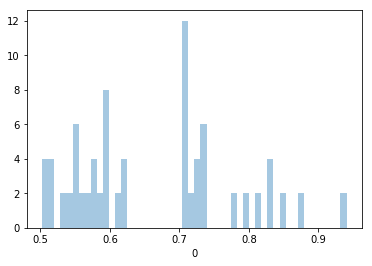

,level_0,level_1,0
388579,soy free,peanut free,0.940721
307025,peanut free,soy free,0.940721
312836,pescatarian,kosher,0.871690
210388,kosher,pescatarian,0.871690
126234,drink,alcoholic,0.851944
6262,alcoholic,drink,0.851944
422329,tree nut free,peanut free,0.829673
307075,peanut free,tree nut free,0.829673
288712,oregon,portland,0.829149
329152,portland,oregon,0.829149


In [16]:
#Look at some other correlation pairs in the data
corrmat = raw.corr()
print(corrmat.shape)
c = corrmat.unstack().reset_index()
#take a look at the distribution of the higher correlated pairs.
c = c.loc[(c[0]!=1)&(c[0]>.50)]
#plot a histogram
fig = sns.distplot(c[0],kde=False,bins=50)
plt.show()
c.sort_values(by=0,ascending=False).head(15)

In [17]:
#look at all that non-sense
#what makes for a bad recipe?
bad = raw.loc[raw['rating']<2]
cols = []
usage = []
#append attribute names and the percentage used in the data
for col in bad.select_dtypes(include=['float64']):
    cols.append(col)
    usage.append(bad[col].mean())
#pop the 'rating' entry out for plotting purposes'
cols.pop(0)
usage.pop(0)
bad_atts = pd.DataFrame(
    sorted(zip(map(lambda x: round(x, 4), usage), 
               cols), reverse=True))
bad_atts.head(15)

,0,1
0,0.3037,bon appétit
1,0.2895,peanut free
2,0.2801,vegetarian
3,0.2801,soy free
4,0.2411,tree nut free
5,0.2345,drink
6,0.2293,pescatarian
7,0.2265,kosher
8,0.2213,gourmet
9,0.2067,wheat/gluten-free


In [18]:
#more nonsense. What about a good recipe?
good = raw.loc[raw['rating']>0]
cols = []
usage = []
#append attribute names and the percentage used in the data
for col in good.select_dtypes(include=['float64']):
    cols.append(col)
    usage.append(good[col].mean())
#pop the 'rating' entry out for plotting purposes'
cols.pop(0)
usage.pop(0)
good_atts = pd.DataFrame(
    sorted(zip(map(lambda x: round(x, 4), usage), 
               cols), reverse=True))
good_atts.head(15)

,0,1
0,0.4830,bon appétit
1,0.4330,peanut free
2,0.4172,soy free
3,0.3635,tree nut free
4,0.3502,vegetarian
5,0.3449,gourmet
6,0.3177,kosher
7,0.3101,pescatarian
8,0.2789,quick & easy
9,0.2489,wheat/gluten-free


In [19]:
#look at some sparsely used ingredients
lesscommon = ingreds[ingreds[0]<10]
lesscommon.head(25)

,0,1
26,9.95,milk/cream
27,9.76,fruit
28,9.23,vegan
29,8.93,kid-friendly
30,8.82,egg
31,8.55,spring
32,8.38,herb
33,8.19,garlic
34,7.56,salad
35,7.46,dairy


In [20]:
#these are more of hte kinds of features i am interested in.
#lets ask random forest what it thinks the features should be.
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
rfc = ensemble.RandomForestClassifier(n_estimators=100)

/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [21]:
'''Y = plotdf.rating

X = raw.drop(['rating','title'],1)
rfc.fit(X,Y)
print(rfc.score(X,Y))

print(cross_val_score(rfc,X,Y,cv=5))
#This time capture output into a dataframe for easier veiwing
feature_sigs = pd.DataFrame(
    sorted(zip(map(lambda x: round(x, 4), rfc.feature_importances_), 
               X.columns), reverse=True))
feature_sigs.rename(columns={0:'sig',1:'feature'},inplace=True)#rename int columns
feature_sigs.head(30)'''

"Y = plotdf.rating\n\nX = raw.drop(['rating','title'],1)\nrfc.fit(X,Y)\nprint(rfc.score(X,Y))\n\nprint(cross_val_score(rfc,X,Y,cv=5))\n#This time capture output into a dataframe for easier veiwing\nfeature_sigs = pd.DataFrame(\n    sorted(zip(map(lambda x: round(x, 4), rfc.feature_importances_), \n               X.columns), reverse=True))\nfeature_sigs.rename(columns={0:'sig',1:'feature'},inplace=True)#rename int columns\nfeature_sigs.head(30)"

In [22]:
'''#use the last 300
last300 = feature_sigs.feature.tail(300)
last300 = raw[last300]'''

'#use the last 300\nlast300 = feature_sigs.feature.tail(300)\nlast300 = raw[last300]'

In [23]:
'''first100 = feature_sigs.feature.head(100)
first100 = raw[first100]
list(first100)'''

'first100 = feature_sigs.feature.head(100)\nfirst100 = raw[first100]\nlist(first100)'

In [25]:
'''corrmat = last300.corr()
print(corrmat.shape)
c = corrmat.unstack().reset_index()
#take a look at the distribution of the higher correlated pairs.
c = c.loc[(c[0]!=1)&(c[0]>.50)]
#plot a histogram
fig = sns.distplot(c[0],kde=False,bins=50)
plt.show()
c.sort_values(by=0,ascending=False).head(15)'''

'corrmat = last300.corr()\nprint(corrmat.shape)\nc = corrmat.unstack().reset_index()\n#take a look at the distribution of the higher correlated pairs.\nc = c.loc[(c[0]!=1)&(c[0]>.50)]\n#plot a histogram\nfig = sns.distplot(c[0],kde=False,bins=50)\nplt.show()\nc.sort_values(by=0,ascending=False).head(15)'

In [26]:
'''Y = Y
X = first100
rfc.fit(X,Y)
print(rfc.score(X,Y))

print(cross_val_score(rfc,X,Y,cv=5))'''

'Y = Y\nX = first100\nrfc.fit(X,Y)\nprint(rfc.score(X,Y))\n\nprint(cross_val_score(rfc,X,Y,cv=5))'

In [34]:
from sklearn.svm import SVC
svc = SVC(kernel='linear')
#svc.fit(X,Y)
#svc.score(X,Y)

In [28]:
'''#So far the model is terrible.
from sklearn.feature_selection import VarianceThreshold
Y = np.where(raw.rating >4,1,0)
X = raw.drop(['title','rating'],1)
feat_sel = VarianceThreshold(threshold=(.2 * (1 - .2)))
X = feat_sel.fit_transform(X)'''

"#So far the model is terrible.\nfrom sklearn.feature_selection import VarianceThreshold\nY = np.where(raw.rating >4,1,0)\nX = raw.drop(['title','rating'],1)\nfeat_sel = VarianceThreshold(threshold=(.2 * (1 - .2)))\nX = feat_sel.fit_transform(X)"

In [29]:
'''print(X.shape)
feat_sel.get_params()'''

'print(X.shape)\nfeat_sel.get_params()'

In [30]:
'''svc.fit(X,Y)
svc.score(X,Y)'''

'svc.fit(X,Y)\nsvc.score(X,Y)'

In [31]:
#interesting that you only lose 4% accuracy by removing all but 12 attributes

In [36]:
X = raw.drop(['title','rating'],1)
Y = np.where(raw.rating >4,1,0)

# Create the RFE object and compute a cross-validated score.
#svc = SVC(kernel="rbf")
# The "accuracy" scoring is proportional to the number of correct
# classifications
#svc.fit(X,Y)

Optimal number of features : 644


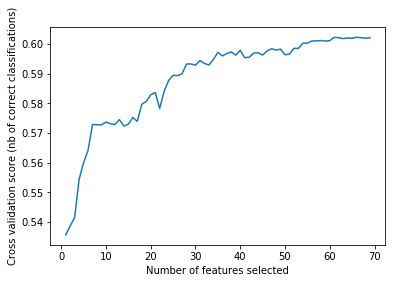

In [37]:
rfecv = RFECV(estimator=svc, step=10, cv=2,
              scoring='accuracy')
rfecv.fit(X, Y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()